<center><h1>Khan dataset</h1></center>


The goal here is to try to find nice clusterings of the different cuisines. In particular, we hope to compare the clustering that we observe to the clustering induced by average linkage, as well as the LIP hierarchical clustering.

Note that this is a little tricky for the algorithm since here, we do not assume the connection matrix to be sparse. Instead, we have a very dense similarity matrix that the algorithm is trying to tackle.

# I. Download the data and create the similarity matrix

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import scipy as sc
import seaborn as sb
import sklearn as sk
import sys
import time

sys.path.append('../')
from convex_hc_denoising import *
from convex_hc_ADMM import *
from hierarchical_path import *
from projections import *
from utils import *

SIGMA = 25
N_NEIGHBORS = 10
ALPHA = 0.95
TOL = 0.01
MAXITERFISTA = 200
SAVEFILE = 'khan.pkl'
USE_TRAINING_SET = True

if USE_TRAINING_SET == 1:
    data = pd.DataFrame.from_csv("../data/khan_train.csv")
else:
    data = pd.DataFrame.from_csv("../data/khan_test.csv")
MAXITERFISTA2 =50
D = np.exp(-cdist(data, data)**2/(2*SIGMA))
nn = np.zeros(D.shape)
for i in range(D.shape[0]):
    nn_n = [u for u in np.argsort(D[i,:])[-(N_NEIGHBORS+1):] if u!=i]
    nn[i, nn_n] = 1
nn = nn +nn.T
nn[nn>1] = 1
#np.fill_diagonal(nn, 1)

K = sc.sparse.csc_matrix(nn)
n_nodes = K.shape[0]

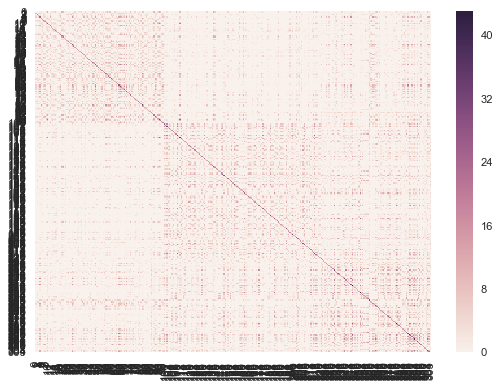

In [2]:
sb.heatmap((K.dot(K)).todense())

In [3]:
K = K.dot(K)

## II. Run the procedure

In [4]:
n_nodes = K.shape[0]
indices = K.nonzero()
mask = []
for i in range(K.nnz):
    mask += [indices[0][i]*n_nodes+indices[1][i]]
mask = np.array(mask)


I = sc.sparse.eye(n_nodes)
delta_k=sc.sparse.lil_matrix((n_nodes, n_nodes**2))
for ii in range(n_nodes):
    ind =K[ii, :].nonzero()[1]
    delta_k[ii, ii * n_nodes + ind] = K[ii, ind]
    delta_k[ii, ii + ind * n_nodes] = -K[ii, ind]
    delta_k[ii, ii + ii * n_nodes] = 0.0
delta_k = delta_k[:, mask]
delta_k = delta_k.todense()



In [5]:
np.trace(1.0/(n_nodes**2)*np.ones((n_nodes, n_nodes)).dot(K.todense().dot(np.ones((n_nodes, n_nodes)))))

351.03921568627447

In [6]:
ALPHA = 0.95
inc_max = np.trace(1.0/(n_nodes**2)*np.ones((n_nodes, n_nodes)).dot(K.todense().dot(np.ones((n_nodes, n_nodes)))))
inc_min = ALPHA * np.sqrt(np.sum(np.square(delta_k.T.dot(np.eye(n_nodes))),axis=-1)).sum() +\
          (1-ALPHA) * np.sum(np.abs(delta_k.T.dot(np.eye(n_nodes))))
ratio = abs(inc_max / inc_min)
print('ratio: %f'% ratio)

ratio: 0.002382


In [7]:

TOL = 0.01
MAXITERFISTA = 200
LAMBDAS = ratio *np.array([1e-3, 2*1e-3, 3*1e-3, 5*1e-3, 6*1e-3, 7*1e-3, 8*1e-3, 1e-2,
                     5*1e-2, 0.1, 0.3, 0.5, 0.7, 0.8, 1.0, 2.0, 5.0,10,100])
INPUTFILE = 'recipes'
SAVEFILE = 'khan_results.pkl'

import logging
logger = logging.getLogger('myapp')
fh = logging.FileHandler('khan_results.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh) 
logger.setLevel(logging.DEBUG)


from hierarchical_path import *
pi_prev = np.eye(n_nodes)
pi_FISTA, time_FISTA, evol_rank_FISTA = compute_reg_path(K, ALPHA, pi_warm_start=pi_prev,
                                                 mode= 'FISTA', verbose=True,
                                                 lambdas = LAMBDAS,
                                                 logger = logger, savefile=SAVEFILE)


pi_ADMM, time_ADMM, evol_rank_ADMM = compute_reg_path(K, ALPHA, pi_warm_start=pi_prev,
                                                 mode= 'ADMM', verbose=True,
                                                 lambdas = LAMBDAS,
                                                 logger = logger, savefile=SAVEFILE)

('lmax', 1213991.9999999998, 'gamma', 2.7561604018637152e-05)
('max q, p', 1.0, -1.0, 0.70759603926444414, -0.70759603926444414)
('max q, p', 1.0, -1.0, 0.70808075993313191, -0.70808075993313191)
('max q, p', 1.0, -1.0, 0.70827441828992921, -0.70827441828992921)
('time:', 14.417349815368652)
('inc = ', 0)
('lmax', 1213991.9999999998, 'gamma', 2.7561604018637152e-05)
('max q, p', 1.0, -1.0, 0.70902706705479124, -0.70902706705479124)
('max q, p', 1.0, -1.0, 0.70938610531303703, -0.70938610531303703)
('max q, p', 1.0, -1.0, 0.7096040286488503, -0.7096040286488503)
('time:', 13.428592920303345)
('inc = ', 1)
('lmax', 1213991.9999999998, 'gamma', 2.7561604018637152e-05)
('max q, p', 1.0, -1.0, 0.71041544225616537, -0.71041544225616537)
('max q, p', 1.0, -1.0, 0.71088268984452996, -0.71088268984452996)
('max q, p', 1.0, -1.0, 0.71113202604796821, -0.71113202604796821)
('time:', 11.9232759475708)
('inc = ', 0)
('lmax', 1213991.9999999998, 'gamma', 2.7561604018637152e-05)
('max q, p', 1.0, -1.

LinAlgError: SVD did not converge

In [8]:
for k in np.sort(pi_ADMM.keys()):
    plt.figure()
    sb.heatmap(pi_ADMM[k]['pi'].T.dot(pi_ADMM[k]['pi']))
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(pi_ADMM[k]['pi'].T.dot(pi_ADMM[k]['pi']))))
    

NameError: name 'pi_ADMM' is not defined

In [ ]:
for k in np.sort(pi_FISTA.keys()):
    plt.figure()
    sb.heatmap(pi_FISTA[k]['pi'].T.dot(pi_FISTA[k]['pi']))
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(pi_FISTA[k]['pi'].T.dot(pi_FISTA[k]['pi']))))
    

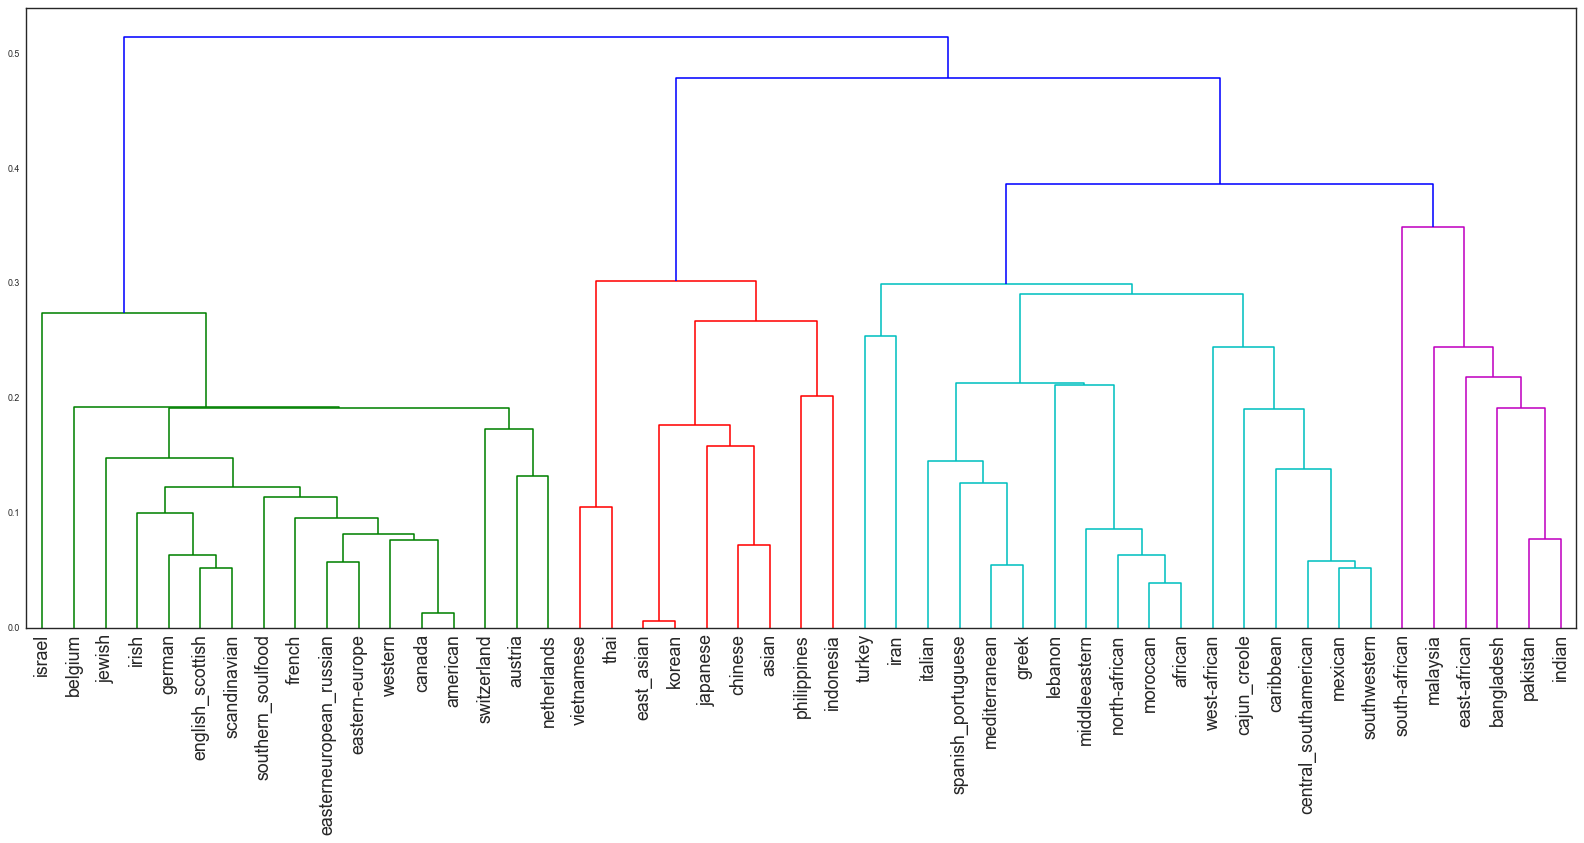

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
sb.set_context('paper')
sb.set_style('white')
Z_avg_linkage = linkage(np.array(D)[np.triu_indices(49,1)], method ='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_avg_linkage, labels =D.index.values,leaf_font_size=16)


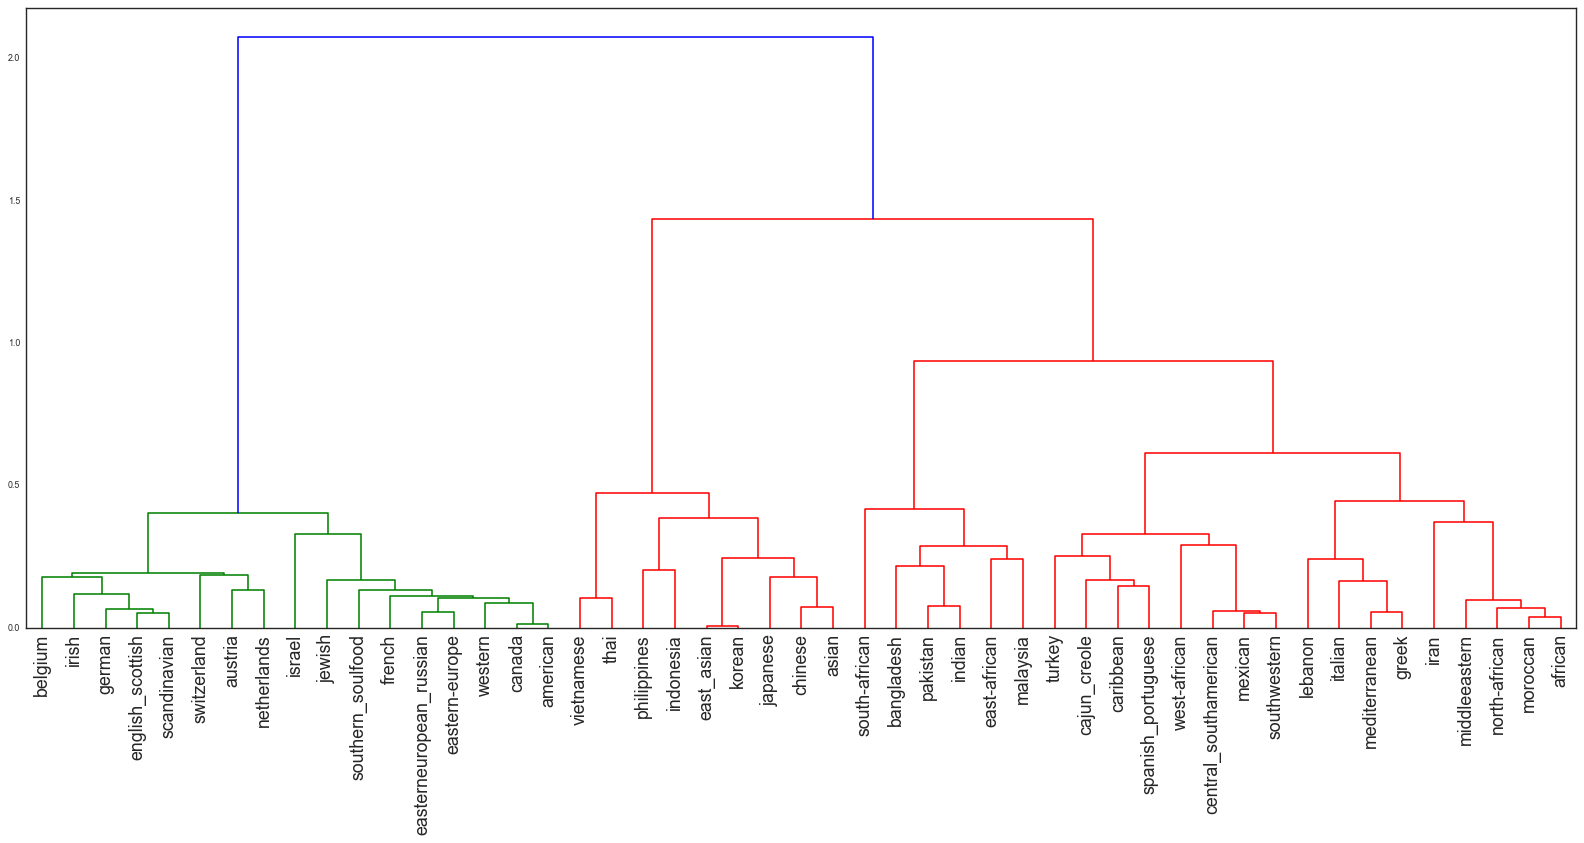

In [101]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
sb.set_context('paper')
sb.set_style('white')
Z_ward = linkage(np.array(D)[np.triu_indices(49,1)], metric = 'precomputed', method ='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_ward,labels =D.index.values,leaf_font_size=16)

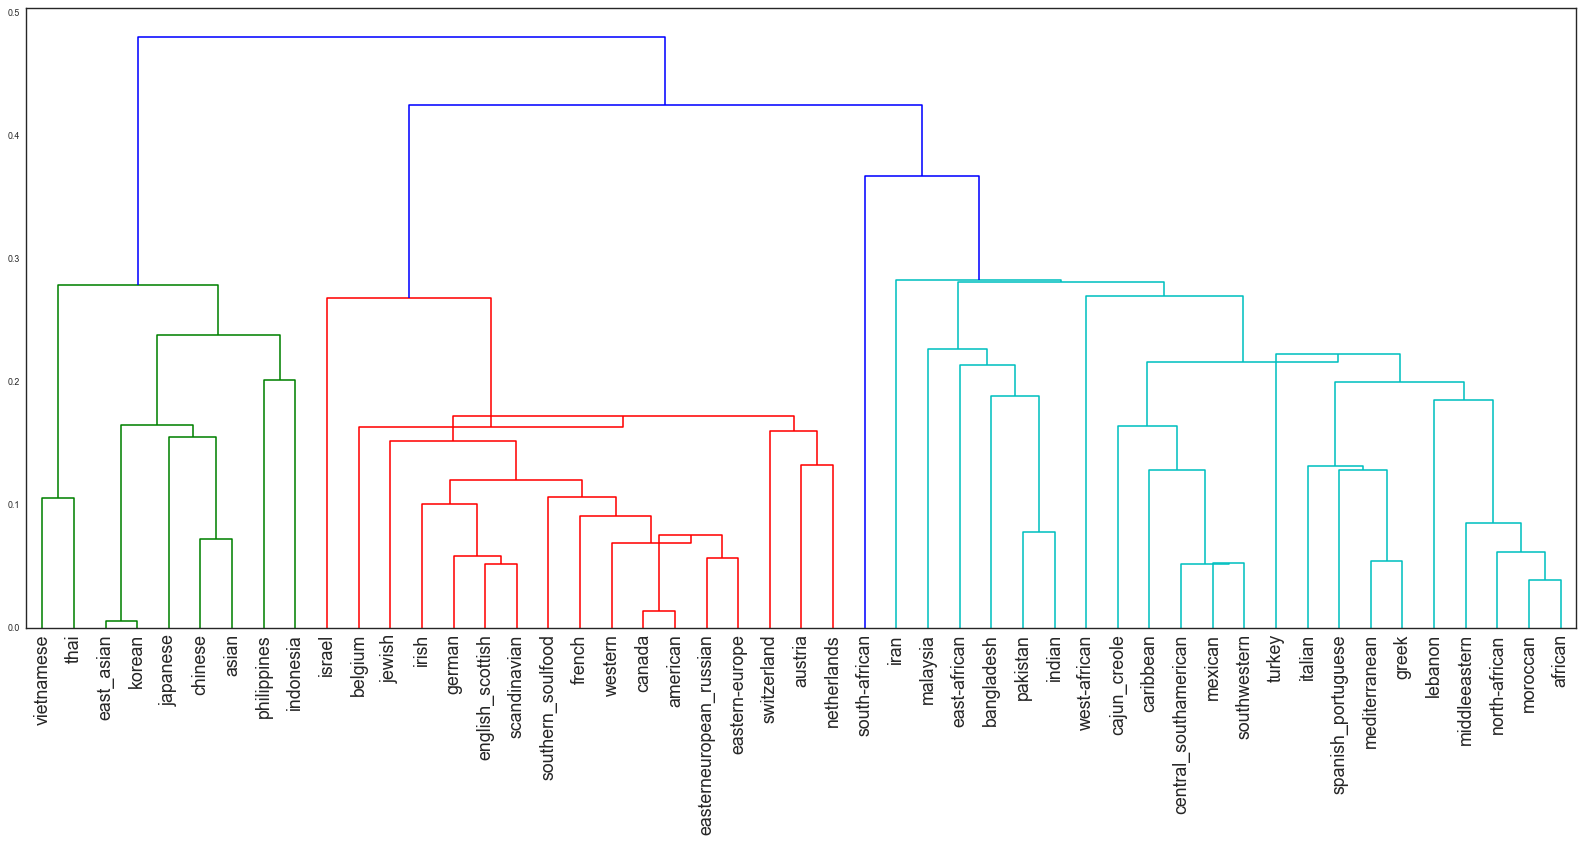

In [102]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
sb.set_context('paper')
sb.set_style('white')
Z_median = linkage(np.array(D)[np.triu_indices(49,1)], metric= 'precomputed', method ='median')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_median,labels =D.index.values,leaf_font_size=16)

In [30]:
Z_ward = Z
print(Z[:2,:])

[[  2.00000000e+01   3.40000000e+01   5.82711245e-03   2.00000000e+00]
 [  1.40000000e+01   4.40000000e+01   1.33551569e-02   2.00000000e+00]]


In [ ]:
def compute_rank_correlation(D, Z, type_hc="tree", lambdas = None):
    #### The goal of this function is to compare the multiscale representations that the algorithm induce
    #### Each algorithm induces a distance 
    N_NODES = D.shape[0]
    sim = np.zeros((N_NODES, N_NODES))
    if type_hc == 'tree':
        assignements = {i: [i] for i in range(N_NODES)}
        for i in range(Z.shape[0]):
            a =  Z[i, 0]
            b =  Z[i, 1]
            assignements[N_NODES + i] = list(assignements[a]) + list(assignements[b])
            for aa in list(assignements[a]) + list(assignements[b]):
                for bb in list(assignements[a]) + list(assignements[b]):
                    sim[int(aa), int(bb)] = sim[int(aa), int(bb)] + 1.0/N_NODES
            ## This creates a distance 
        #sim = sim / np.diag(sim).max()
    else:
        lambdas = np.sort(lambdas)
        increment_lambda = np.diff(lambdas)
        DELTA_LAMBDA = lambdas[-1] - lambdas[0]
        if lambdas is None:
            print('Error: must provide the lambda path')
            return None
        for i, l in enumerate(np.sort(lambdas)):
            dist = 1- 0.5 * cdist(Z[l], Z[l], 'cosine')
            if i > 0:
                increment_distance = dist - dist_old
                sim += increment_lambda[i-1]/DELTA_LAMBDA * increment_distance
            else:
                sim = dist
            dist_old = dist
    sim = pd.DataFrame(sim, columns = D.columns, index=D.index)
    return sim

In [166]:
def compute_RSM(D, Z, type_hc="tree", lambdas = None):
    N_NODES = D.shape[0]
    sim = np.zeros((N_NODES, N_NODES))
    if type_hc == 'tree':
        assignements = {i: [i] for i in range(N_NODES)}
        for i in range(Z.shape[0]):
            a =  Z[i, 0]
            b =  Z[i, 1]
            assignements[N_NODES + i] = list(assignements[a]) + list(assignements[b])
            for aa in list(assignements[a]) + list(assignements[b]):
                for bb in list(assignements[a]) + list(assignements[b]):
                    sim[int(aa), int(bb)] = sim[int(aa), int(bb)] + 1.0/N_NODES
        #sim = sim / np.diag(sim).max()
    else:
        lambdas = np.sort(lambdas)
        increment_lambda = np.diff(lambdas)
        DELTA_LAMBDA = lambdas[-1] - lambdas[0]
        if lambdas is None:
            print('Error: must provide the lambda path')
            return None
        for i, l in enumerate(np.sort(lambdas)):
            dist = 1- 0.5 * cdist(Z[l], Z[l], 'cosine')
            if i > 0:
                increment_distance = dist - dist_old
                sim += increment_lambda[i-1]/DELTA_LAMBDA * increment_distance
            else:
                sim = dist
            dist_old = dist
    sim = pd.DataFrame(sim, columns = D.columns, index=D.index)
    return sim


In [167]:
RSM_ward = compute_RSM(D, Z_ward, 'tree')
RSM_median = compute_RSM(D, Z_median, 'tree')
RSM_avg_linkage = compute_RSM(D, Z_avg_linkage, 'tree')

In [140]:
RSM_ADMM  = compute_RSM(D, {k: pi_ADMM[k]['pi'] for k in pi_ADMM.keys()},  type_hc="none", lambdas =pi_ADMM.keys())

In [141]:
RSM_FISTA  = compute_RSM(D, {k: pi_FISTA[k]['pi'] for k in pi_FISTA.keys()},  type_hc="none", lambdas =pi_FISTA.keys())

In [71]:
np.asarray(sim.values).dot(np.diagflat(1.0/sim.values.sum(1)))

array([[ 0.05833333,  0.01204819,  0.02173913, ...,  0.02083333,
         0.01298701,  0.02189781],
       [ 0.00833333,  0.06024096,  0.00724638, ...,  0.00694444,
         0.03896104,  0.00729927],
       [ 0.025     ,  0.01204819,  0.05797101, ...,  0.02777778,
         0.01298701,  0.02919708],
       ..., 
       [ 0.025     ,  0.01204819,  0.02898551, ...,  0.0625    ,
         0.01298701,  0.03649635],
       [ 0.00833333,  0.03614458,  0.00724638, ...,  0.00694444,
         0.05194805,  0.00729927],
       [ 0.025     ,  0.01204819,  0.02898551, ...,  0.03472222,
         0.01298701,  0.05109489]])

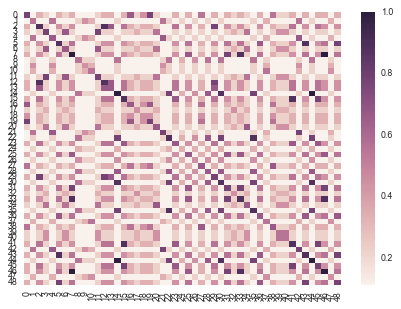

In [153]:
sb.heatmap(RSM_ward)

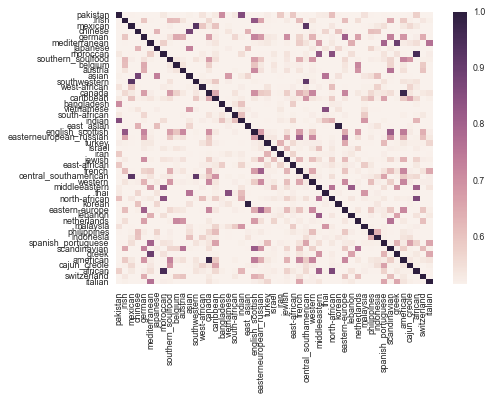

In [142]:
sb.heatmap(RSM_ADMM)

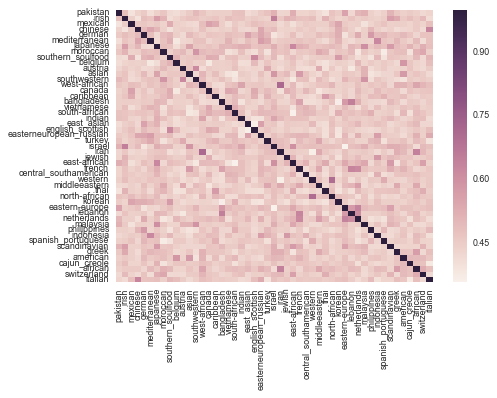

In [143]:
sb.heatmap(RSM_FISTA)

In [150]:
e

,pakistan,irish,mexican,chinese,german,mediterranean,japanese,moroccan,southern_soulfood,belgium,...,philippines,indonesia,spanish_portuguese,scandinavian,greek,american,cajun_creole,african,switzerland,italian
pakistan,1.000000,0.515012,0.517159,0.514922,0.514999,0.514866,0.514972,0.532613,0.514966,0.515001,...,0.516614,0.515858,0.517856,0.515010,0.514908,0.514935,0.516791,0.578728,0.514997,0.514946
irish,0.515012,1.000000,0.514946,0.514971,0.597258,0.518051,0.514748,0.514985,0.620475,0.614753,...,0.516248,0.515075,0.516305,0.654651,0.515161,0.588510,0.521721,0.514978,0.536042,0.519533
mexican,0.517159,0.514946,1.000000,0.515695,0.514931,0.514848,0.514934,0.517657,0.523652,0.514974,...,0.518845,0.532503,0.548593,0.514961,0.514921,0.534964,0.563500,0.534566,0.514992,0.514561
chinese,0.514922,0.514971,0.515695,1.000000,0.514974,0.515015,0.630654,0.515005,0.514946,0.515004,...,0.610354,0.603405,0.515000,0.516087,0.515015,0.516157,0.516310,0.514950,0.515015,0.515014
german,0.514999,0.597258,0.514931,0.514974,1.000000,0.514908,0.514811,0.517681,0.545694,0.649283,...,0.525979,0.517086,0.515279,0.732061,0.515787,0.689515,0.515395,0.522843,0.643455,0.514866
mediterranean,0.514866,0.518051,0.514848,0.515015,0.514908,1.000000,0.515012,0.578252,0.518698,0.514974,...,0.515837,0.514966,0.797587,0.518072,0.896448,0.526858,0.537082,0.551800,0.515013,0.766582
japanese,0.514972,0.514748,0.514934,0.630654,0.514811,0.515012,1.000000,0.515012,0.514943,0.514993,...,0.572220,0.527177,0.514989,0.528274,0.515011,0.514829,0.515129,0.514983,0.515004,0.514996
moroccan,0.532613,0.514985,0.517657,0.515005,0.517681,0.578252,0.515012,1.000000,0.514937,0.514999,...,0.514941,0.516539,0.542247,0.515345,0.545776,0.516377,0.514763,0.953418,0.514975,0.522335
southern_soulfood,0.514966,0.620475,0.523652,0.514946,0.545694,0.518698,0.514943,0.514937,1.000000,0.533537,...,0.523257,0.520938,0.535912,0.566163,0.515142,0.726851,0.686043,0.515163,0.519939,0.520490
belgium,0.515001,0.614753,0.514974,0.515004,0.649283,0.514974,0.514993,0.514999,0.533537,1.000000,...,0.515067,0.515172,0.514969,0.568359,0.514984,0.533294,0.515552,0.514963,0.588693,0.514915


In [152]:
e

array([[ 0.77777778,  0.11111111,  0.33333333, ...,  0.33333333,
         0.11111111,  0.33333333],
       [ 0.11111111,  0.55555556,  0.11111111, ...,  0.11111111,
         0.33333333,  0.11111111],
       [ 0.33333333,  0.11111111,  0.88888889, ...,  0.44444444,
         0.11111111,  0.44444444],
       ..., 
       [ 0.33333333,  0.11111111,  0.44444444, ...,  1.        ,
         0.11111111,  0.55555556],
       [ 0.11111111,  0.33333333,  0.11111111, ...,  0.11111111,
         0.44444444,  0.11111111],
       [ 0.33333333,  0.11111111,  0.44444444, ...,  0.55555556,
         0.11111111,  0.77777778]])

In [176]:
from scipy.spatial.distance import pdist
distances_all_hc_clusterings = pdist([e.values[np.triu_indices(N_NODES)] 
                                      for e in [RSM_ADMM, RSM_FISTA, RSM_ward, RSM_avg_linkage, RSM_median]],
                                    'cosine')
    
distances_all_hc_clusterings_mat = np.zeros((5,5))
distances_all_hc_clusterings_mat[np.triu_indices(5,1)] = distances_all_hc_clusterings
distances_all_hc_clusterings_mat = distances_all_hc_clusterings_mat + distances_all_hc_clusterings_mat.T
distances_all_hc_clusterings_mat = pd.DataFrame(distances_all_hc_clusterings_mat,
                    index = ['ADMM', 'FISTA', 'ward', 'avg_linkage', 'RSM_median'],
                    columns = ['ADMM', 'FISTA', 'ward', 'avg_linkage', 'RSM_median']
                   )
test = pd.DataFrame(np.vstack([e.values[np.triu_indices(N_NODES)] 
                                      for e in [RSM_ADMM, RSM_FISTA, RSM_ward, RSM_avg_linkage, RSM_median]]),
                    index = ['ADMM', 'FISTA', 'ward', 'avg_linkage', 'RSM_median']
                   )

In [180]:
test.T.corr('kendall')

,ADMM,FISTA,ward,avg_linkage,RSM_median
ADMM,1.000000,0.153654,0.375370,0.414491,0.429346
FISTA,0.153654,1.000000,0.090059,0.088237,0.114141
ward,0.375370,0.090059,1.000000,0.917646,0.526028
avg_linkage,0.414491,0.088237,0.917646,1.000000,0.584974
RSM_median,0.429346,0.114141,0.526028,0.584974,1.000000


In [181]:
distances_all_hc_clusterings_mat 

,ADMM,FISTA,ward,avg_linkage,RSM_median
ADMM,0.000000,0.010213,0.134245,0.155946,0.169627
FISTA,0.010213,0.000000,0.157461,0.186313,0.198540
ward,0.134245,0.157461,0.000000,0.030178,0.060204
avg_linkage,0.155946,0.186313,0.030178,0.000000,0.030566
RSM_median,0.169627,0.198540,0.060204,0.030566,0.000000


In [192]:
dist

array([[ 0.        ,  0.76160542,  0.74917356, ...,  0.6287459 ,
         0.82393497,  0.81780697],
       [ 0.76160542,  0.        ,  0.75561948, ...,  0.69173118,
         0.80746611,  0.81793621],
       [ 0.74917356,  0.75561948,  0.        , ...,  0.67016857,
         0.81842565,  0.81175632],
       ..., 
       [ 0.6287459 ,  0.69173118,  0.67016857, ...,  0.        ,
         0.75980167,  0.74965001],
       [ 0.82393497,  0.80746611,  0.81842565, ...,  0.75980167,
         0.        ,  0.87838836],
       [ 0.81780697,  0.81793621,  0.81175632, ...,  0.74965001,
         0.87838836,  0.        ]])

['EEurope' 'Europe' 'US' 'africa' 'asia' 'hispanic' 'islands' 'medit'
 'south asia']


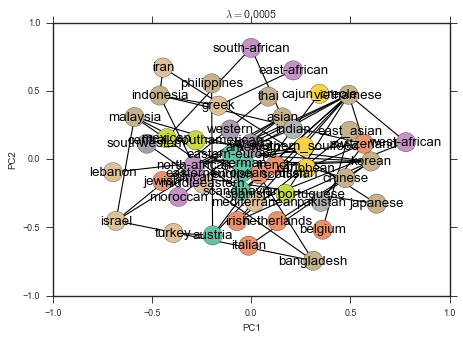

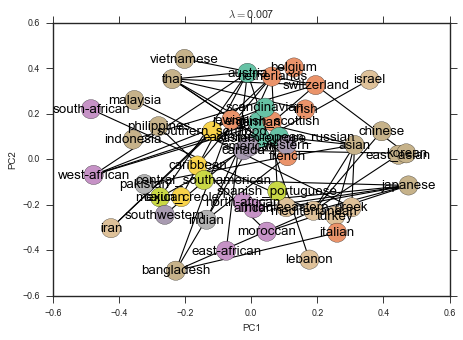

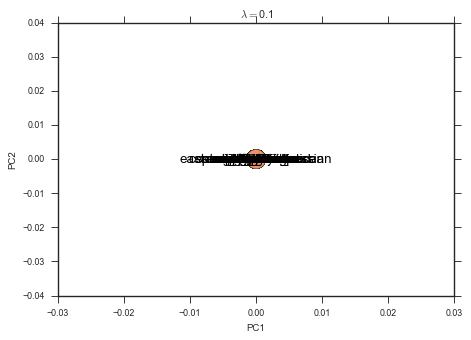

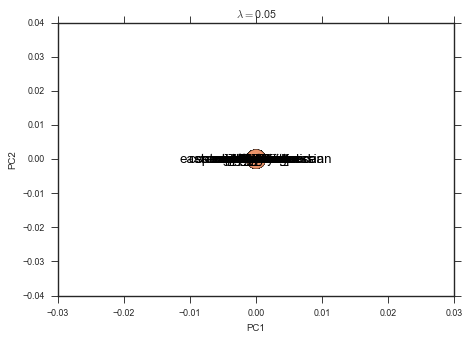

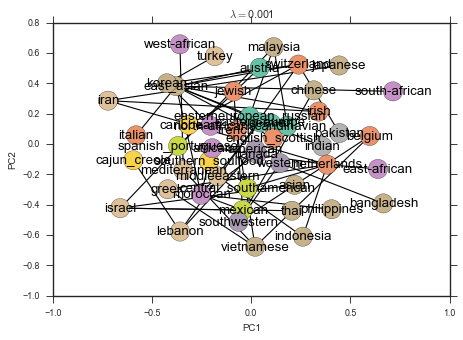

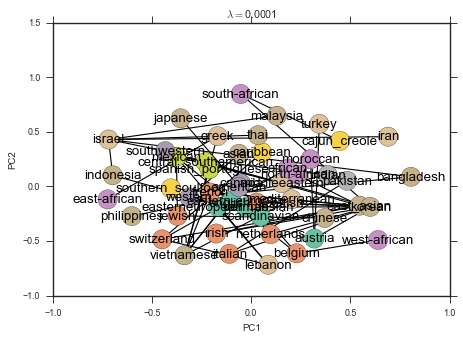

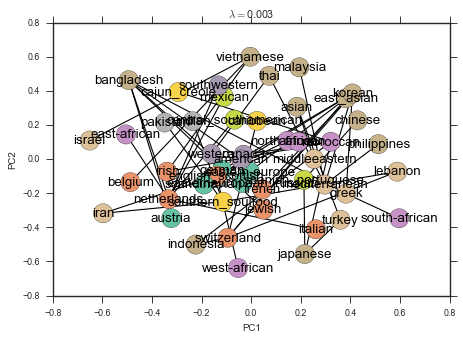

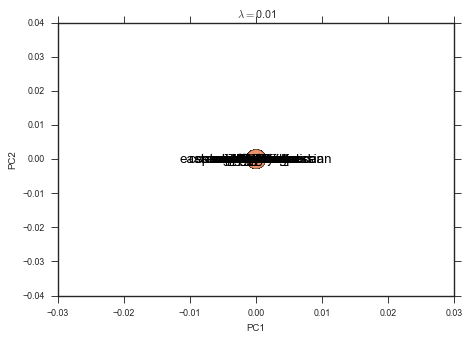

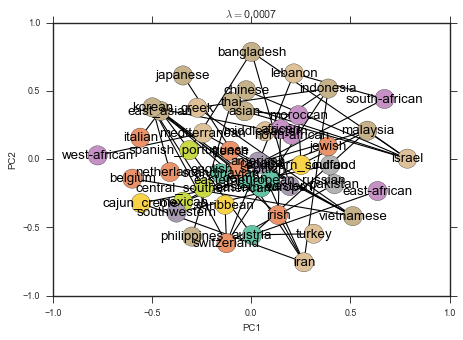

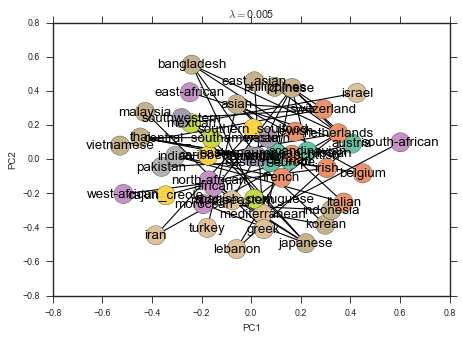

In [203]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import networkx as nx
import seaborn as sb
pca = MDS(n_components=2)
cmap = plt.get_cmap("Set2")
xx = np.linspace(0,1,len(np.unique(labels.values())))
lab = np.unique(labels.values())
print lab
colors_dic = {lab[i]: cmap(xx[i]) for i in range(len(lab ))}

for k in pi_ADMM.keys():
        X_t =pca.fit_transform(pi_ADMM[k]['pi'].T)
        dist = 1 - cdist(pi_ADMM[k]['pi'].T, pi_ADMM[k]['pi'].T, 'cosine')
        T = nx.minimum_spanning_tree(nx.from_numpy_matrix(dist))
        pos = {}
        for n in range(T.number_of_nodes()):
            pos[n]=tuple(X_t[n,:])
        sb.set_style('white')
        sb.set_style('ticks')
        plt.figure()
        nx.draw_networkx(T,pos,node_color=[colors_dic[labels[v]] for v in D.index],
                labels = {i: D.index[i] for i in range(len(labels))}, fontsize=4)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(r'$\lambda =$'+str(k))
        plt.savefig('../FIG/cuisines/2211_MDS_ADMM_MST_cuisines'+str(k)+'.pdf')


In [204]:
help(nx.draw_networkx)

Help on function draw_networkx in module networkx.drawing.nx_pylab:

draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
    Draw the graph G using Matplotlib.
    
    Draw the graph with Matplotlib with options for node positions,
    labeling, titles, and many other drawing features.
    See draw() for simple drawing without labels or axes.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See networkx.layout for functions that compute node positions.
    
    arrows : bool, optional (default=True)
       For directed graphs, if True draw arrowheads.
    
    with_labels :  bool, optional (default=True)
       Set to True to draw labels on the nodes.
    
    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
    
    nodelist : l

['EEurope' 'Europe' 'US' 'africa' 'asia' 'hispanic' 'islands' 'medit'
 'south asia']


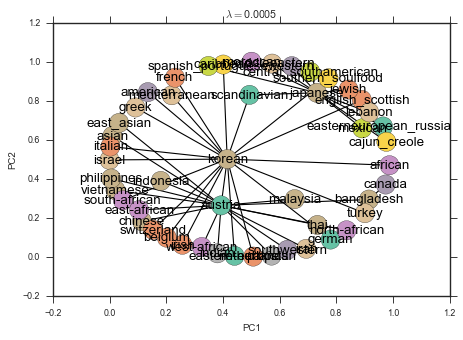

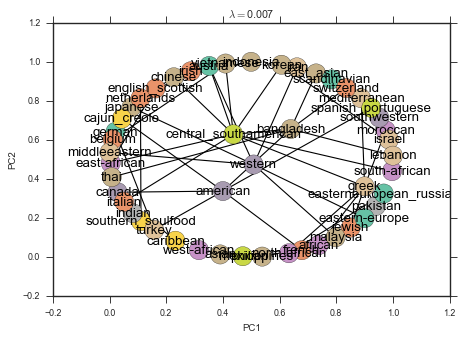

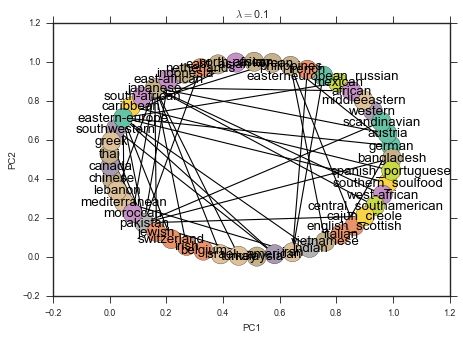

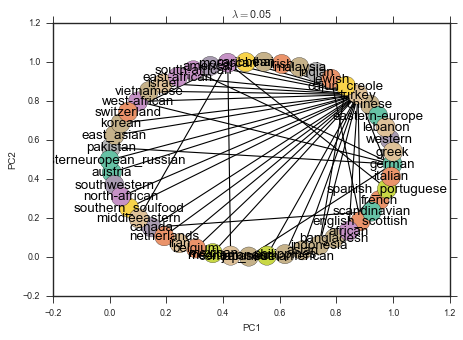

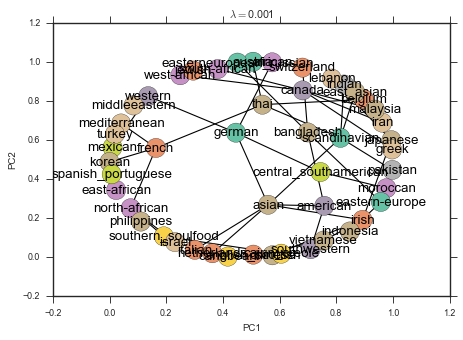

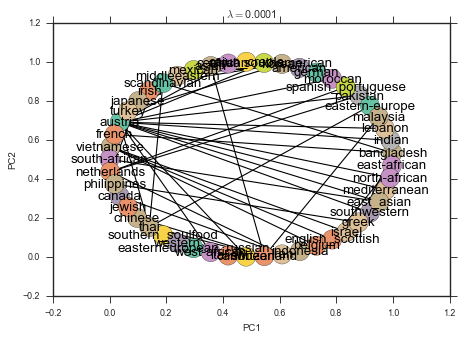

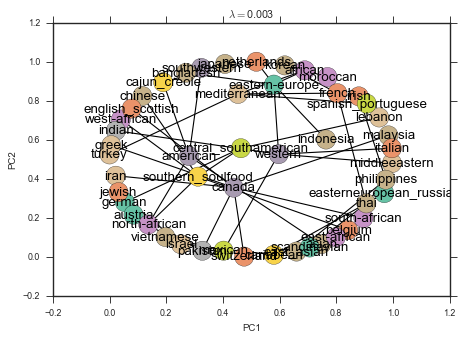

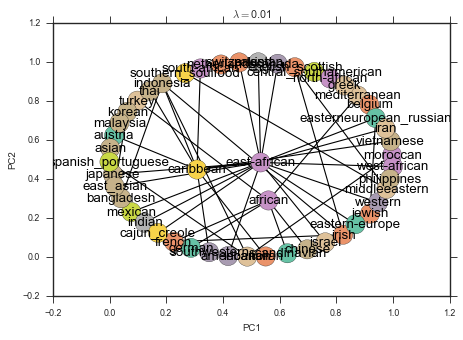

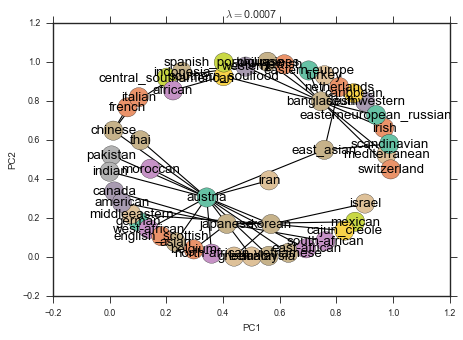

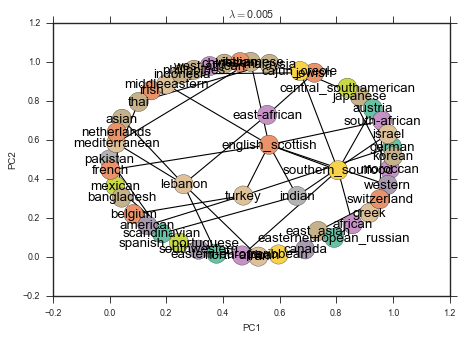

In [205]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import networkx as nx
import seaborn as sb
pca = MDS(n_components=2)
cmap = plt.get_cmap("Set2")
xx = np.linspace(0,1,len(np.unique(labels.values())))
lab = np.unique(labels.values())
print lab
colors_dic = {lab[i]: cmap(xx[i]) for i in range(len(lab ))}

for k in pi_FISTA.keys():
        X_t =pca.fit_transform(pi_FISTA[k]['pi'].T)
        dist = 1 - cdist(pi_FISTA[k]['pi'].T, pi_FISTA[k]['pi'].T, 'cosine')
        T = nx.minimum_spanning_tree(nx.from_numpy_matrix(dist))
        pos = {}
        for n in range(T.number_of_nodes()):
            pos[n]=tuple(X_t[n,:])
        sb.set_style('white')
        sb.set_style('ticks')
        plt.figure()
        nx.draw_networkx(T, node_color=[colors_dic[labels[v]] for v in D.index],
                labels = {i: D.index[i] for i in range(len(labels))}, fontsize=4)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(r'$\lambda =$'+str(k))
        plt.savefig('../FIG/cuisines/2211_MDS_FISTA_MST_cuisines'+str(k)+'.pdf')



In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import networkx as nx
import seaborn as sb
pca = MDS(n_components=2)
for k in pi_ADMM.keys():
    try:
        X_t =pca.fit_transform(pi_ADMM[k].todense().T)
        dist = cdist(pi_ADMM[k].todense().T, pi_ADMM[k].todense().T)
        T =nx.minimum_spanning_tree(nx.from_numpy_array(dist))
        pos = {}
        for n in range(T.number_of_nodes()):
            pos[n]=tuple(X_t[n,:])
        sb.set_style('white')
        sb.set_style('ticks')
        plt.figure()
        nx.draw_networkx(T,pos,node_color=[colors_dic[labels[v]] for v in D.index],
                labels = {i: D.index[i] for i in range(len(labels))}, fontsize=4)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(r'$\lambda =$'+str(k))
        plt.savefig('FIG/cuisines/MDS_ADMM_MST_cuisines'+str(k)+'.pdf')
    except:
        pass

/Users/cdonnat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


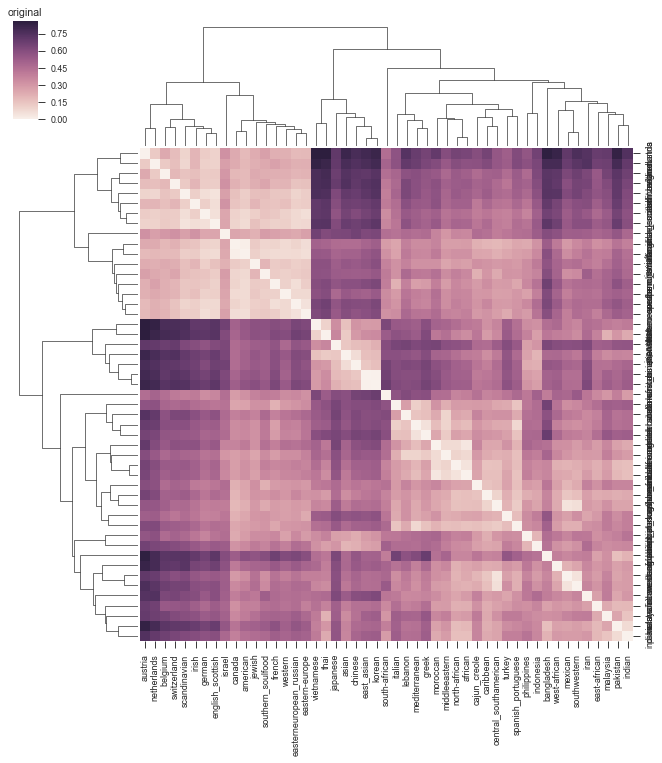

In [206]:
fig=plt.figure()
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(D.values, method='average')
sb.clustermap(D, row_linkage=linkage, col_linkage=linkage)

#sb.clustermap(pd.DataFrame(1-D.value,index=A.columns, columns=A.columns))
plt.title("original")
plt.savefig("original_cuisine_11_22.pdf")

In [221]:
### Effective rank is not sufficient as a measure
dist = {k: cdist(pi_ADMM[k]['pi'].T, pi_ADMM[k]['pi'].T) for k in pi_ADMM.keys()}

(array([ 780.,  107.,   62.,   84.,   12.,   83.,   42.,    3.,    1.,    2.]),
 array([  1.73612232e-08,   3.26369381e-06,   6.51002640e-06,
          9.75635899e-06,   1.30026916e-05,   1.62490242e-05,
          1.94953568e-05,   2.27416893e-05,   2.59880219e-05,
          2.92343545e-05,   3.24806871e-05]),
 <a list of 10 Patch objects>)

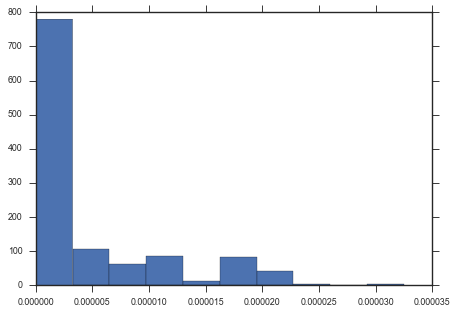

In [224]:
plt.hist(dist[k][np.triu_indices(49,1)])

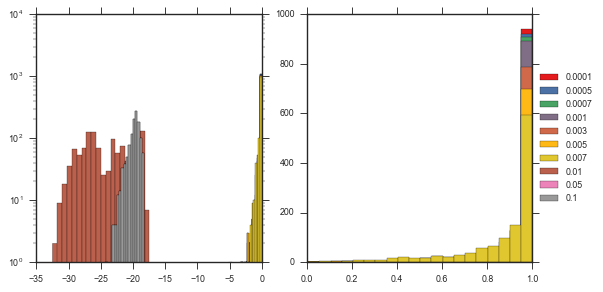

In [271]:
dist = {k: cdist(pi_ADMM[k]['pi'].T, pi_ADMM[k]['pi'].T, 'cosine') for k in pi_ADMM.keys()}
fig, ax = plt.subplots(1,2, figsize=(8,4))
cmap = plt.get_cmap('Set1')
colors = [cmap(xx) for xx in np.linspace(0,1,len(pi_ADMM.keys()))]
for i, k in enumerate(np.sort(pi_ADMM.keys())):
    ax[0].hist(np.log(dist[k][np.triu_indices(49,1)]), bins=20, label=str(k), color=colors[i], log=True)
    ax[1].hist(dist[k][np.triu_indices(49,1)], bins=20, label=str(k), color=colors[i])
ax[1].legend(loc = 'center left', bbox_to_anchor = (1.0,0.5))
plt.savefig('cuisines_distribution_distances_cosine_ADMM.pdf')

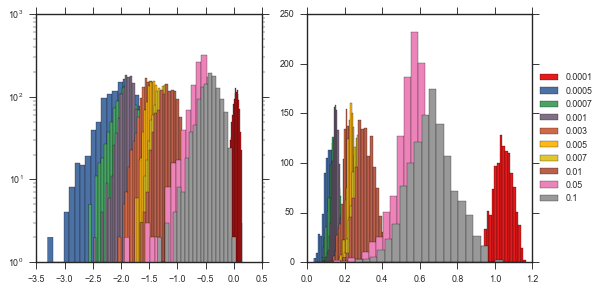

In [273]:
dist = {k: cdist(pi_FISTA[k]['pi'].T, pi_FISTA[k]['pi'].T, 'euclidean') for k in pi_ADMM.keys()}
fig, ax = plt.subplots(1,2, figsize=(8,4))
cmap = plt.get_cmap('Set1')
colors = [cmap(xx) for xx in np.linspace(0,1,len(pi_FISTA.keys()))]
for i, k in enumerate(np.sort(pi_FISTA.keys())):
    ax[0].hist(np.log(dist[k][np.triu_indices(49,1)]), bins=20, label=str(k), color=colors[i], log=True)
    ax[1].hist(dist[k][np.triu_indices(49,1)], bins=20, label=str(k), color=colors[i])
ax[1].legend(loc = 'center left', bbox_to_anchor = (1.0,0.5))
plt.savefig('cuisines_distribution_distances_euclidean_FISTA.pdf')

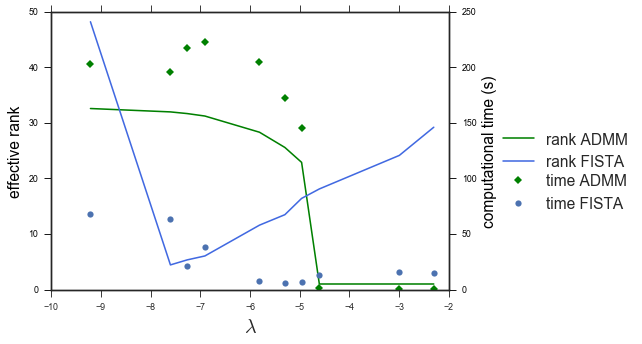

In [219]:
fig, ax1 = plt.subplots()
ax1.plot([np.log(l) for l in np.sort(pi_FISTA.keys())],
         [efficient_rank(pi_ADMM[l]['pi'].T.dot(pi_ADMM[l]['pi'])) for l in np.sort(pi_FISTA.keys())],
         'green',label="rank ADMM")
ax1.plot([np.log(l) for l in np.sort(pi_FISTA.keys())],
         [efficient_rank(pi_FISTA[l]['pi'].T.dot(pi_FISTA[l]['pi'])) for l in np.sort(pi_FISTA.keys())],
         'royalblue',label="rank FISTA")
#ax1.plot([l for l in np.sort(pi_FISTA.keys())],[np.trace(pi_FISTA[l]['pi']) for l in np.sort(pi_FISTA.keys())], 'royalblue',label="rank FISTA")
ax1.set_xlabel(r'$\lambda$',fontsize=18)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('effective rank', color='black',fontsize=14)
ax1.tick_params('y', colors='black')
plt.legend(loc="center left", bbox_to_anchor=(1.1,0.5),fontsize=14)

ax2 = ax1.twinx()
#s2 = np.sin(2 * np.pi * t)
ax2.plot([np.log(l) for l in np.sort(pi_ADMM.keys())], [pi_ADMM[l]['time'] for l in np.sort(pi_ADMM.keys())],
         color="green", marker="D",linestyle=" ",label="time ADMM")
ax2.plot([np.log(l) for l in np.sort(pi_FISTA.keys())], [pi_FISTA[l]['time'] for l in np.sort(pi_FISTA.keys())],
         marker="o",linestyle=" ",label="time FISTA")
ax2.set_ylabel('computational time (s)', color='black',fontsize=14)
ax2.tick_params('y', colors='black')

fig.tight_layout()
plt.legend(loc="center left", bbox_to_anchor=(1.1,0.35),fontsize=14)
plt.show()